# M5-Convnets with pretrained datasets(cat vs dog)
VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture for ImageNet. Although it is a bit of an older model, far from the current state of the art and somewhat heavier than many other recent models, we chose it because its architecture is similar to what you are already familiar with, and easy to understand without introducing any new concepts. This may be your first encounter with one of these cutesie model names -- VGG, ResNet, Inception, Inception-ResNet, Xception... 
There are two ways to leverage a pre-trained network: **feature extraction** and **fine-tuning**.  

In [ ]:
import keras
import os, shutil
print(keras.__version__)

2.9.0


In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',            # specify which weight checkpoint to initialize the model from
                  include_top=False,             # which refers to including or not the densely-connected classifier on top of the network.
                  input_shape=(150, 150, 3))     # the shape of the image tensors that we will feed to the network

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

# 1，Feature extraction
## What is feature extraction?
Feature extraction consists of using the **representations** learned by a previous network to **extract interesting features** from new samples. These features are then run through a **new classifier**, which is trained from scratch.

## Feature extraction parts
As we saw previously, convnets used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely-connected classifier. The first part is called the "**convolutional base**" of the model. In the case of convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a **new classifier on top of the output**. 

## Why do we do Feature extraction like this?
The representations learned by the convolutional base are likely to be more generic and therefore more reusable. Additionally, representations found in densely-connected layers no longer contain any information about where objects are located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional feature maps. For problems where object location matters, densely-connected features would be largely useless.

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. 

In our case, since the ImageNet class set did contain multiple dog and cat classes, it is likely that it would be beneficial to reuse the information contained in the densely-connected layers of the original model. However, we will chose not to, in order to cover the more general case where the class set of the new problem does not overlap with the class set of the original model.

The final feature map has shape (4, 4, 512). That's the feature on top of which we will stick a densely-connected classifier. 

## Two ways we could proceed:  
1, Running the **convolutional base** over our dataset, recording its **output to a Numpy array on disk**, then using this data as **input to** a standalone densely-connected **classifier** similar to those you have seen in the first chapters of this book. This solution is very fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at all.  
2, Extending the model we have (conv_base) by adding Dense layers on top, and running the whole thing end-to-end on the input data. This allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. However, for this same reason, this technique is far more expensive than the first one.

In [ ]:
'''Extract images as Numpy arrays as well as their labels by calling the predict method of the conv_base model.'''

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/storage/tutorials/dogs-vs-cats/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 23ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 18ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 21ms/step


In [ ]:
# The extracted features are currently of shape (samples, 4, 4, 512). 
# We will feed them to a densely-connected classifier, so first we must flatten them to (samples, 8192):
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

# densely-connected classifier with dropout for regularization, and train it on the data and labels that we just recorded:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


100/100 [==============================] - 4s 29ms/step - loss: 0.5770 - acc: 0.6865 - val_loss: 0.4224 - val_acc: 0.8300
Epoch 2/30
100/100 [==============================] - 2s 24ms/step - loss: 0.4078 - acc: 0.8240 - val_loss: 0.3393 - val_acc: 0.8760
Epoch 3/30
100/100 [==============================] - 6s 60ms/step - loss: 0.3454 - acc: 0.8560 - val_loss: 0.3127 - val_acc: 0.8800
Epoch 4/30
100/100 [==============================] - 7s 66ms/step - loss: 0.3063 - acc: 0.8755 - val_loss: 0.2913 - val_acc: 0.8850
Epoch 5/30
100/100 [==============================] - 6s 63ms/step - loss: 0.2797 - acc: 0.8885 - val_loss: 0.2707 - val_acc: 0.8970
Epoch 6/30
100/100 [==============================] - 5s 46ms/step - loss: 0.2684 - acc: 0.8920 - val_loss: 0.2750 - val_acc: 0.8860
Epoch 7/30
100/100 [==============================] - 3s 27ms/step - loss: 0.2435 - acc: 0.9095 - val_loss: 0.2566 - val_acc: 0.8990
Epoch 8/30
100/100 [==============================] - 3s 25ms/step - loss: 0.226

In [ ]:
# save models after training:
model.save('Convnets with feature extraction pretrained datasets(cat vs dog).h5')

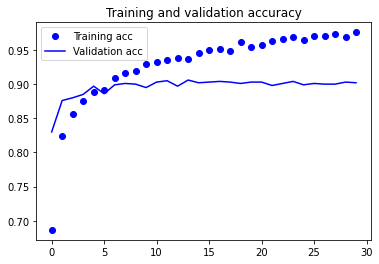

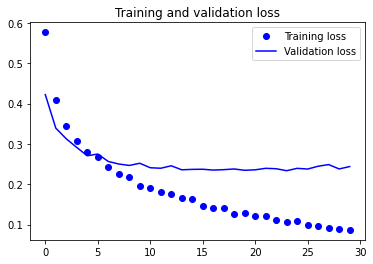

In [ ]:
# plot loss
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Validation accuracy of about 90%(last simple network 81%). However, overfitting from 5 -- with dropout without **augmentation**, which is **essential** to preventing overfitting with **small image** datasets.

# Fine tuning
### turn on GPU setting
much slower and more expensive, but leverage data augmentation : extending the conv_base model and running it end-to-end on the inputs. 

In [ ]:
# add a model (like our conv_base) to a Sequential model just like add a layer
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


The convolutional base of VGG16 has 14,714,688 parameters. The classifier we are adding on top has 2 million parameters.

# Freeze the convolutional base. 
"Freezing" a layer or set of layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were previously learned by the convolutional base would get modified during training. Since the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In [ ]:
# In Keras, freezing a network is done by setting its trainable attribute to False:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights)) #30

This is the number of trainable weights before freezing the conv base: 30


In [ ]:
# Only the weights from the two Dense layers that we added will be trained. 
# That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). 
conv_base.trainable = False 

In [ ]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [ ]:
# Training our model, with data augmentation  
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
100/100 - 493s - loss: 0.5976 - acc: 0.6765 - val_loss: 0.4552 - val_acc: 0.8260 - 493s/epoch - 5s/step
Epoch 2/30
100/100 - 22s - loss: 0.4826 - acc: 0.7865 - val_loss: 0.3735 - val_acc: 0.8600 - 22s/epoch - 216ms/step
Epoch 3/30
100/100 - 22s - loss: 0.4466 - acc: 0.7975 - val_loss: 0.3364 - val_acc: 0.8710 - 22s/epoch - 218ms/step
Epoch 4/30
100/100 - 23s - loss: 0.4068 - acc: 0.8235 - val_loss: 0.3231 - val_acc: 0.8660 - 23s/epoch - 226ms/step
Epoch 5/30
100/100 - 22s - loss: 0.3802 - acc: 0.8385 - val_loss: 0.2941 - val_acc: 0.8840 - 22s/epoch - 215ms/step
Epoch 6/30
100/100 - 22s - loss: 0.3779 - acc: 0.8385 - val_loss: 0.2921 - val_acc: 0.8760 - 22s/epoch - 216ms/step
Epoch 7/30
100/100 - 22s - loss: 0.3593 - acc: 0.8405 - val_loss: 0.2772 - val_acc: 0.8840 - 22s/epoch - 218ms/step
Epoch 8/30
100/100 - 22s - loss: 0.3589 - acc: 0.8485 - val_loss: 0.2789 - val_acc: 0.8870 - 22s/epoch - 224ms/step
Epoch 9/30
100/100 - 22s - loss: 0.3480 - acc: 0.8555 - val_loss: 0.2632 

In [ ]:
model.save('Convnets with feature extraction pretrained cats_and_dogs_small_convebase_trainableOFF.h5')

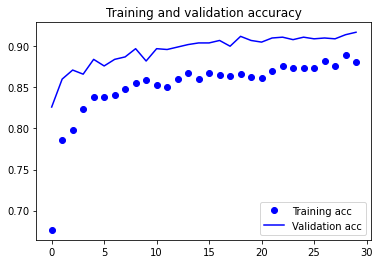

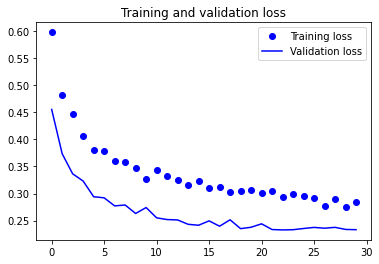

In [ ]:
# Plot 91% accuracy
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Fine-tuning
Consists in unfreezing **a few** of the **top layers** of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the fully-connected classifier) and these top layers. 

This is called "fine-tuning" because it **slightly adjusts** the **more abstract representations** of the model being reused, in order to make them more relevant for the problem at hand.

1) Add your custom network on top of an already trained base network.  
2) Freeze the base network.  
3) Train the part you added.  
4) Unfreeze some layers in the base network.  
5) Jointly train both these layers and the part you added.


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
# Training 94%
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/100
100/100 [==============================] - 25s 229ms/step - loss: 0.2785 - acc: 0.8855 - val_loss: 0.2194 - val_acc: 0.9170
Epoch 2/100
100/100 [==============================] - 25s 251ms/step - loss: 0.2660 - acc: 0.8775 - val_loss: 0.2589 - val_acc: 0.9000
Epoch 3/100
100/100 [==============================] - 25s 255ms/step - loss: 0.2443 - acc: 0.9020 - val_loss: 0.2113 - val_acc: 0.9210
Epoch 4/100
100/100 [==============================] - 24s 237ms/step - loss: 0.2324 - acc: 0.8975 - val_loss: 0.1950 - val_acc: 0.9250
Epoch 5/100
100/100 [==============================] - 24s 236ms/step - loss: 0.1974 - acc: 0.9215 - val_loss: 0.1942 - val_acc: 0.9240
Epoch 6/100
100/100 [==============================] - 23s 225ms/step - loss: 0.1920 - acc: 0.9215 - val_loss: 0.1976 - val_acc: 0.9240
Epoch 7/100
100/100 [==============================] - 23s 227ms/step - loss: 0.2031 - acc: 0.9170 - val_loss: 0.1849 - val_acc: 0.9310
Epoch 8/100
100/100 [===========================

In [ ]:
model.save('Convnets with fineTuning pretrained cats_and_dogs_small_2.h5')

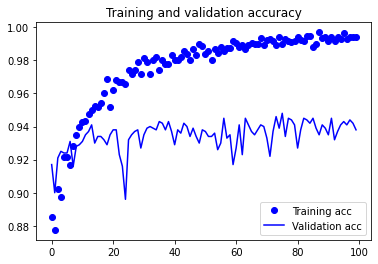

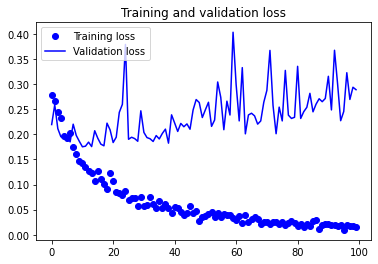

In [ ]:
# normal plotting, result unreadable
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

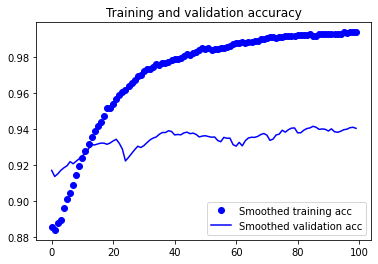

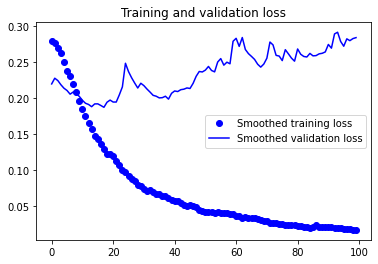

In [ ]:
# Optimized plotting
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These curves look much cleaner and more stable. Accuracy has 2-3% absolute improvement(91%-94%) while loss curve does not show any real improvement (in fact, it is deteriorating). 

# !!!How could accuracy improve if the loss isn't decreasing? 
The answer is: what we display is an average of pointwise loss values, but what actually matters for accuracy is the distribution of the loss values, not their average, since accuracy is the result of a binary thresholding of the class probability predicted by the model. The model may still be improving even if this isn't reflected in the average loss.

In [ ]:
# evaluate this model on the test data: 97% on 2000(10%) images
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


test acc: 0.9380000233650208
